# Topic Modeling w NMF, SVD

Here's a term-document matrix.
![matrix](images/document_term.png)

We can decompose it into a tall, thin matrix times a wide, short matrix (and poss a diag in between)

We'll try Singular Value Decomposition (SVD) and Non-negaitve Matrix Factorization (NMF)

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
np.set_printoptions(suppress=True)

### Data Setup

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [5]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Look at some data. The below is prob from 'comp.graphics'.

In [6]:
print("\n".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

 >In article <1993Apr19.020359.26996@sq.sq.com>, msb@sq.sq.c

In [8]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], 
      dtype='<U18')

Target attrib is int index of category

In [9]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1], dtype=int64)

In [10]:
num_topics, num_top_words = 6,8

We can use sklearn to extract word counts

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [12]:
vectorizer = CountVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documents,vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape

(2034, 26576)

In [13]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [14]:
vocab = np.array(vectorizer.get_feature_names())

In [15]:
vocab.shape

(26576,)

In [16]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel', 'counselees',
       'counselor', 'count'], 
      dtype='<U80')

## SVD

The SVD algorithm factorizes a matrix into one matrix with orthogonal columns and one with orthogonal rows (along with a diagonal matrix, which contains the relative importance of each factor).

![SVD](images/svd_fb.png)

SVD is an exact decomposition, since the matrices it creates are big enough to fully cover the original matrix. SVD is extremely widely used in linear algebra, and specifically in data science, including:

- semantic analysis
- collaborative filtering/recommendations (winning entry for Netflix Prize)
- calculate Moore-Penrose pseudoinverse
- data compression
- principal component analysis (will be covered later in course)

In [17]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

Wall time: 24.4 s


In [18]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [27]:
# now we confirm that U, s, Vh is a decomposition of Vectors
# we can do this with the following.
vectors_reconstructed = np.dot(U * s, Vh)

In [30]:
np.allclose(vectors, vectors_reconstructed)

True

In [42]:
x = np.array([0,1])
y = np.array([0,1])

In [44]:
x @ y

1

Allclose tells us this decomp is good. Let's do it another way.

In [45]:
reconstructed_vectors = U @ np.diag(s) @ Vh
np.linalg.norm(reconstructed_vectors - vectors) # frobenius, sq el't and add all
np.allclose(reconstructed_vectors, vectors) # checks each el't

True

In [31]:
# confirm that U, Vh are orthonormal
product = np.dot(U, Vh)
np.fill_diagonal(product, 0)

In [32]:
product

array([[ 0.        , -0.00005216,  0.00075593, ...,  0.00001956,
         0.00003911,  0.00226399],
       [-0.01180971,  0.        , -0.0005135 , ...,  0.00001167,
         0.00002334,  0.00003739],
       [ 0.0036624 , -0.01258836,  0.        , ..., -0.0000444 ,
        -0.00008879, -0.00015916],
       ..., 
       [-0.00043759, -0.00425605,  0.00074763, ..., -0.00021339,
        -0.00042679,  0.00053759],
       [ 0.00576556,  0.00304193, -0.00002426, ..., -0.00001116,
        -0.00002232, -0.00133598],
       [ 0.00030212,  0.00023288, -0.00002906, ...,  0.00000218,
         0.00000436, -0.00000786]])

In [36]:
product.any() == 0

False

That didn't work. Here's the answer.
Recall what orthonormal/orthogonal is:

An orthogonal matrix is a square matrix whose columns and rows are orthogonal unit vectors (i.e., orthonormal vectors), i.e.

$$ Q^{\mathrm {T} }Q=QQ^{\mathrm {T} }=I, Q^{\mathrm {T} }Q=QQ^{\mathrm {T} }=I, $$
where $ I $ is the identity matrix.

This leads to the equivalent characterization: a matrix Q is orthogonal if its transpose is equal to its inverse:

$${\displaystyle Q^{\mathrm {T} }=Q^{-1}.}$$

In [47]:
# check that getting transpose of U vs V.
# multiply by transpose, then compare to identity
np.allclose(U.T @ U, np.eye(U.shape[0])) # U.T is rows x cols so we get col of U by col of U
np.allclose(Vh @ Vh.T, np.eye(Vh.shape[0]))

True

s, singular values give us measures of importance.  See how these drop off and what relative importance looks like.

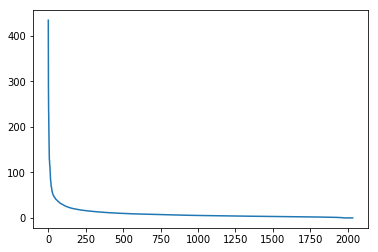

In [37]:
plt.plot(s)

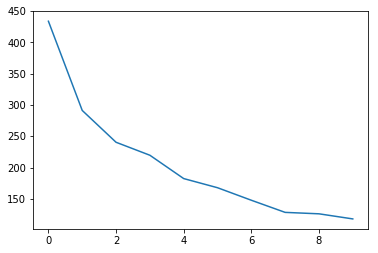

In [38]:
plt.plot(s[:10])

In [48]:
num_top_words = 8

In [51]:
def show_topics(a):
    """
    Pass in our matrix V--this looks up words corresp to values.
    vocab words were in alph order, this finds the largest
    values in cols that corresp to these vocab words
    """
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [52]:
show_topics(Vh[:5]) # get first 5 cols of Vh, top topic words

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display']

These are different topics--e.g. jesus etc prob about religion

In [53]:
show_topics(Vh[:10]) # more

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

This was an unsupervised algo--we got the type of topic clusters we expect.

Cols of U corresp to a particular post.

In A, words are the rows, hashtags/documents are  cols
In U, words are rows, cols are topics
Vt: Topics by post

## NMF

![faces](images/face_pca.png)

In SVD it's possible to have neg values.

Rather than constraining our factors to be orthogonal, another idea would to constrain them to be non-negative. NMF is a factorization of a non-negative data set $V$: $$ V = W H$$ into non-negative matrices $W,\; H$. Often positive factors will be more easily interpretable (and this is the reason behind NMF's popularity).

![pic](images/face_nmf.png)

Nonnegative matrix factorization (NMF) is a non-exact factorization that factors into one skinny positive matrix and one short positive matrix. NMF is NP-hard and non-unique. There are a number of variations on it, created by adding different constraints.

![NMF](images/nmf_doc.png)

### Sklearn NMF

In [54]:
m,n = vectors.shape
d = 5 # num topics

In [55]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [56]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF

Topic Frequency-Inverse Document Frequency (TF-IDF) is a way to normalize term counts by taking into account how often they appear in a document, how long the document is, and how commmon/rare the term is.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)

In [57]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [58]:
W1 = clf.fit_transform(vectors_tfidf)
H1= clf.components_

In [59]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

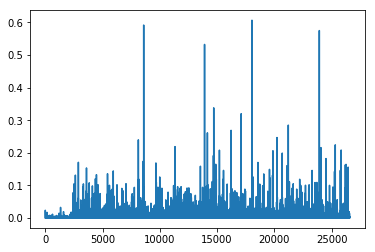

In [60]:
plt.plot(clf.components_[0])

In [61]:
clf.reconstruction_err_

43.71292605795276

### NMF Summary

Benefits: Fast and easy to use!

Downsides: took years of research and expertise to create

Notes:

- For NMF, matrix needs to be at least as tall as it is wide, or we get an error with fit_transform
- Can use df_min in CountVectorizer to only look at words that were in at least k of the split texts

### NMF from Scratch w SGD

Applying SGD to NMF
Goal: Decompose $V\;(m \times n)$ into $$V \approx WH$$ where $W\;(m \times d)$ and $H\;(d \times n)$, $W,\;H\; >= \;0$, and we've minimized the Frobenius norm of $V-WH$.

Approach: We will pick random positive $W$ & $H$, and then use SGD to optimize.

To use SGD, we need to know the gradient of the loss function.

In [62]:
lam = 1e3
lr = 1e-2 # learning rate
m,n = vectors_tfidf.shape

In [71]:
m,n

(2034, 26576)

In [63]:
W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [64]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

In [65]:
mu = 1e-6
def grads(M,W,H):
    R = W@H-M
    # penalize negative matrices
    return R@H.T + penalty(W, mu)*lam, W.T@R + penalty(H, mu)*lam # dW, dH

In [66]:
def penalty(M, mu):
    return np.where(M>=mu, 0, np.min(M-mu,0))

In [67]:
def upd(M,W,H,lr):
    # update from grad descent
    dW, dH = grads(M,W,H)
    W -= -lr*dW; H -= lr*dH #update wt, etc.

In [77]:
def report(M,W,H):
    # give updates on progress. W@H is an approx of M, so wee how close.
    print(np.linalg.norm(M-W@H), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [69]:
W = np.abs(np.random.normal(scale=0.01, size=(m,d)))
H = np.abs(np.random.normal(scale=0.01, size=(d,n)))

In [76]:
W.shape, H.shape

((2034, 5), (5, 26576))

In [78]:
report(vectors_tfidf, W, H)

44.4250870397 5.31872787895e-08 9.0245931568e-08 0 0


In [79]:
upd(vectors_tfidf, W, H, lr)

In [80]:
report(vectors_tfidf,W,H)

44.4273184041 -0.00143543828988 -7.7466785549e-05 78 290


Now let's keep updating and get a report.

In [81]:
for i in range(50):
    # update 50 iters
    upd(vectors_tfidf,W,H,lr)
    if i % 10 == 0: report(vectors_tfidf, W, H)

44.4317474686 -0.017483737225 -8.47241211815e-05 161 334


C:\Python35\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
C:\Python35\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


nan -inf nan 1230 0


C:\Python35\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


nan nan nan 0 0
nan nan nan 0 0
nan nan nan 0 0


In [82]:
show_topics(H)

['zyxel earthly earned earnest earnestly earnings earnshaw ears',
 'zyxel earthly earned earnest earnestly earnings earnshaw ears',
 'zyxel earthly earned earnest earnestly earnings earnshaw ears',
 'zyxel earthly earned earnest earnestly earnings earnshaw ears',
 'zyxel earthly earned earnest earnestly earnings earnshaw ears']

## Pytorch

In [83]:
import torch
import torch.cuda as tc
from torch.autograd import Variable

In [84]:
def V(M): return Variable(M, requires_grad=True)

In [85]:
v = vectors_tfidf.todense()

In [87]:
t_vectors = torch.Tensor(v.astype(np.float32))

In [88]:
mu = 1e-5

In [95]:
def grads_t(M, W, H):
    R = W.mm(H)-M
    return (R.mm(H.t()) + penalty_t(W, mu)*lam, 
        W.t().mm(R) + penalty_t(H, mu)*lam) # dW, dH

def penalty_t(M, mu):
    return (M<mu).type(torch.FloatTensor)*torch.clamp(M - mu, max=0.)

def upd_t(M, W, H, lr):
    dW,dH = grads_t(M,W,H)
    W.sub_(lr*dW); H.sub_(lr*dH) # sub_ is subtract

def report_t(M,W,H): 
    print((M-W.mm(H)).norm(2), W.min(), H.min(), (W<0).sum(), (H<0).sum())

In [92]:
t_W = torch.FloatTensor(m,d)
t_H = torch.FloatTensor(d,n)
t_W.normal_(std=0.01).abs_(); # init w/ normal random variable.
t_H.normal_(std=0.01).abs_();

In [96]:
d=6; lam=100; lr=0.05

In [97]:
for i in range(1000): 
    upd_t(t_vectors,t_W,t_H,lr)
    if i % 100 == 0: 
        report_t(t_vectors,t_W,t_H)
        lr *= 0.9

tensor(44.3939) tensor(-0.0047) tensor(-0.0004) tensor(778) tensor(1324)
tensor(43.7935) tensor(-0.0103) tensor(-0.0091) tensor(1533) tensor(18418)
tensor(43.7667) tensor(-0.0044) tensor(-0.0136) tensor(1743) tensor(20468)
tensor(43.7579) tensor(-0.0046) tensor(-0.0054) tensor(1919) tensor(20609)
tensor(43.7550) tensor(-0.0052) tensor(-0.0029) tensor(2065) tensor(20592)
tensor(43.7543) tensor(-0.0037) tensor(-0.0029) tensor(2239) tensor(22392)
tensor(43.7539) tensor(-0.0031) tensor(-0.0050) tensor(2512) tensor(23250)
tensor(43.7537) tensor(-0.0037) tensor(-0.0045) tensor(2363) tensor(24208)
tensor(43.7536) tensor(-0.0040) tensor(-0.0065) tensor(2291) tensor(24356)
tensor(43.7532) tensor(-0.0036) tensor(-0.0059) tensor(2927) tensor(34437)


In [98]:
show_topics(t_H.numpy())

['space nasa shuttle station sci gov program edu',
 'people don think just objective like say morality',
 'graphics thanks files image file program windows know',
 'god jesus bible believe christian atheism does belief',
 'moon orbit lunar earth launch data spacecraft new']

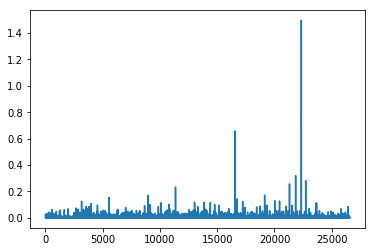

In [99]:
plt.plot(t_H.numpy()[0])

In [100]:
t_W.mm(t_H).max()

tensor(0.4627)

In [101]:
t_vectors.max()

tensor(1.)

### Autograd

In [102]:
x = Variable(torch.ones(2,2), requires_grad=True)

In [103]:
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [104]:
print(x.data)

tensor([[1., 1.],
        [1., 1.]])


In [105]:
print(x.grad)

None


In [106]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward>)


In [107]:
z = y * y * 3
out = z.sum()
print(z,out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward>) tensor(108., grad_fn=<SumBackward0>)


In [108]:
out.backward()
print(x.grad)

tensor([[18., 18.],
        [18., 18.]])


### Autograd for NMF

In [109]:
lam = 1e6

In [110]:
pW = Variable(torch.FloatTensor(m,d), requires_grad=True)
pH = Variable(torch.FloatTensor(d,n), requires_grad=True)
pW.data.normal_(std=0.01).abs_()
pH.data.normal_(std=0.01).abs_();

In [111]:
def report():
    W,H = pW.data, pH.data
    print((M-pW.mm(pH)).norm(2).data[0], W.min(), H.min(), (W<0).sum(), (H<0).sum())

def penalty(A):
    return torch.pow((A<0).type(torch.FloatTensor)*torch.clamp(A, max=0.), 2)

def penalize(): return penalty(pW).mean() + penalty(pH).mean()

def loss(): return (M-pW.mm(pH)).norm(2) + penalize()*lam

In [112]:
M = Variable(t_vectors)

In [113]:
opt = torch.optim.Adam([pW,pH], lr=1e-3, betas=(0.9,0.9))
lr = 0.05
report()

tensor(44.4412) tensor(4.8669e-07) tensor(3.4340e-07) tensor(0) tensor(0)


C:\Python35\lib\site-packages\ipykernel_launcher.py:3: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
for i in range(1000): 
    opt.zero_grad()
    l = loss()
    l.backward() # calculates gradient
    opt.step()
    if i % 100 == 99: 
        report()
        lr *= 0.9     # learning rate annealling

In [ ]:
h = pH.data.numpy()
show_topics(h)

In [ ]:
plt.plot(h[0]);